# Model hiper optimization

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [ ]:
# configs.
%matplotlib inline
# version to read
read_version = "1.2.b - group zone"

# model to save
model_id = "3.2.1 - 060 with zone groups"

pd.set_option("display.max_columns", 500)

path = "../../../data/split"
random_state = 42
print(os.listdir(path))

## Loading training and validation datasets

In [4]:
df = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_train with nan.feather"))
df_val = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

In [5]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [6]:
# Select all non 060 tipo exped.
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
df = df[df["TIPO_EXPED"] == 6]
df_val = df_val[df_val["TIPO_EXPED"] == 6]

In [7]:
df["TIPO_EXPED"].value_counts()

6    62136
Name: TIPO_EXPED, dtype: int64

In [8]:
df["EXISTE_FRAUDE"].value_counts()

False    59570
True      2566
Name: EXISTE_FRAUDE, dtype: int64

In [9]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [10]:
# dropping index variables
# to_drop = ["index"]
# df.drop(to_drop, axis=1, inplace=True)
# to_drop = ["level_0", "index"]
# df_val.drop(to_drop, axis=1, inplace=True)

In [11]:
# dropping NUM_SECU_EXPED
# to_drop = ["NUM_SECU_EXPED"]
# df.drop(to_drop, axis=1, inplace=True)
# df_val.drop(to_drop, axis=1, inplace=True)

In [12]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [13]:
# using only last year
split_date = "2018-09-01"
df_train = df[df["FECHA_SINI"] < split_date].copy()
df_opt = df[df["FECHA_SINI"] >= split_date].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2017-01-01 00:00:00 2018-08-31 00:00:00
2018-09-01 00:00:00 2019-01-31 00:00:00


In [14]:
df_opt["EXISTE_FRAUDE"].value_counts()

False    12904
True       745
Name: EXISTE_FRAUDE, dtype: int64

In [15]:
full_len = df_train.shape[0] + df_opt.shape[0]
df_train.shape[0] / full_len, df_opt.shape[0] / full_len

(0.780336680829149, 0.21966331917085102)

In [16]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [17]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST", "es_gte_5"] # 

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [18]:
X_full_train = df.drop(to_drop, axis=1)
X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
y_full_train = df["EXISTE_FRAUDE"]

In [19]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [20]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

48487, 13649
48487, 13649


In [21]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.037556458432157075, 0.05458275331526119)

In [22]:
y_train.value_counts(dropna=False)

False    46666
True      1821
Name: EXISTE_FRAUDE, dtype: int64

## Defining grid configuration

In [23]:
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm_notebook as tqdm

In [24]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights

array([ 0.52153769, 12.10756041])

In [25]:
list_weights = [{0:1, 1:x} for x in range(3, 60, 3)]
list_weights

[{0: 1, 1: 3},
 {0: 1, 1: 6},
 {0: 1, 1: 9},
 {0: 1, 1: 12},
 {0: 1, 1: 15},
 {0: 1, 1: 18},
 {0: 1, 1: 21},
 {0: 1, 1: 24},
 {0: 1, 1: 27},
 {0: 1, 1: 30},
 {0: 1, 1: 33},
 {0: 1, 1: 36},
 {0: 1, 1: 39},
 {0: 1, 1: 42},
 {0: 1, 1: 45},
 {0: 1, 1: 48},
 {0: 1, 1: 51},
 {0: 1, 1: 54},
 {0: 1, 1: 57}]

In [26]:
"""space = {
    "algo": hp.choice("algo", 
                      [{
                           "model": RandomForestClassifier,
                           "params": {
                                "n_estimators": hp.choice("n_estimators", [40, 80, 120]),  # 100, 400
                                "min_samples_leaf": hp.choice("min_samples_leaf", [4, 55]), # , 65
                                "max_depth": hp.choice("max_depth", [5,  15]), # 10,
                                "max_features": hp.choice("max_features", ['sqrt', 0.5, None]),
                                "class_weight": hp.choice("class_weight", [{0:1, 1:20}, {0:1, 1:30},  {0:1, 1:40}]) ,
                            }
                       },
                       {
                           "model": ExtraTreesClassifier,
                           "params": {
                                "n_estimators": hp.choice("n_estimators", [40, 80, 120]),  # 100, 400
                                "min_samples_leaf": hp.choice("min_samples_leaf", [4, 55]), # , 65
                                "max_depth": hp.choice("max_depth", [5,  15]), # 10,
                                "max_features": hp.choice("max_features", ['sqrt', 0.5, None]),
                                "class_weight": hp.choice("class_weight", [{0:1, 1:20}, {0:1, 1:30},  {0:1, 1:40}]) ,
                            }
                       }
                      ]),
    
}"""

'space = {\n    "algo": hp.choice("algo", \n                      [{\n                           "model": RandomForestClassifier,\n                           "params": {\n                                "n_estimators": hp.choice("n_estimators", [40, 80, 120]),  # 100, 400\n                                "min_samples_leaf": hp.choice("min_samples_leaf", [4, 55]), # , 65\n                                "max_depth": hp.choice("max_depth", [5,  15]), # 10,\n                                "max_features": hp.choice("max_features", [\'sqrt\', 0.5, None]),\n                                "class_weight": hp.choice("class_weight", [{0:1, 1:20}, {0:1, 1:30},  {0:1, 1:40}]) ,\n                            }\n                       },\n                       {\n                           "model": ExtraTreesClassifier,\n                           "params": {\n                                "n_estimators": hp.choice("n_estimators", [40, 80, 120]),  # 100, 400\n                                "min

In [27]:
space = {
    "algo": hp.choice("algo", [RandomForestClassifier, ExtraTreesClassifier]),
    "params": {
        "n_estimators": hp.choice("n_estimators", [40, 200]),
        "min_samples_leaf": hp.quniform("min_samples_leaf", 5, 65, 1),
        "max_depth": hp.quniform("max_depth", 5,  50, 1), # 10,
        "max_features": hp.choice("max_features", ['sqrt', 0.5, None]),
        "class_weight": hp.choice("class_weight", list_weights),
    }
}

In [32]:
evals = 50
pbar = tqdm(total=evals)

def __optimizerFunc(args):
    # pbar.update(0.5)
    # fixed parameters
    args["params"]["verbose"] = 2
    args["params"]["n_jobs"] = -1
    # hardcoded cast
    args["params"]["min_samples_leaf"] = int(args["params"]["min_samples_leaf"])
    args["params"]["max_depth"] = args["params"]["max_depth"]
    
    # grid parameters
    model = args["algo"](**args["params"])
    print(f"Trying: {model}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_opt) 
    pbar.update()
    # greater is better
    return {"loss": -f1_score(y_opt, y_pred), "status": STATUS_OK,}
          
trials = Trials()
__bestClassifier = fmin(fn=__optimizerFunc,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=evals,
                        trials=trials,
                        rstate=np.random.RandomState(random_state)
                        )
pbar.close()

print("{}\n".format(trials.results))

Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
                     criterion='gini', max_depth=8.0, max_features=None,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=14,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
building tree 1 of 200                              
building tree 2 of 200                              
building tree 3 of 200                              
building tree 4 of 200                              
building tree 5 of 200                              
building tree 6 of 200                              
building tree 7 of 200                              
building tree 8 of 200                              
building tree 9 of 200                              
building tree 10 of 200         

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.6s



building tree 38 of 200
building tree 39 of 200                             
building tree 40 of 200                             
building tree 41 of 200                             
building tree 42 of 200                             
building tree 43 of 200                             
building tree 44 of 200                             
building tree 45 of 200                             
building tree 46 of 200                             
building tree 47 of 200                             
building tree 48 of 200                             
building tree 49 of 200                             
building tree 50 of 200                             
building tree 51 of 200                             
building tree 52 of 200                             
building tree 53 of 200                             
building tree 54 of 200                             
building tree 55 of 200                             
building tree 56 of 200                             
building tree 57 of 20

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.8s



building tree 162 of 200                            
building tree 163 of 200                            
building tree 164 of 200                            
building tree 165 of 200                            
building tree 166 of 200                            
building tree 167 of 200                            
building tree 168 of 200                            
building tree 169 of 200                            
building tree 170 of 200                            
building tree 171 of 200                            
building tree 172 of 200                            
building tree 173 of 200                            
building tree 174 of 200                            
building tree 175 of 200                            
building tree 176 of 200                            
building tree 177 of 200                            
building tree 178 of 200                            
building tree 179 of 200                            
building tree 180 of 200                      

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.4s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tree 7 of 40                                                          
building tree 8 of 40                                                          
building tree 9 of 40                                                          
building tree 10 of 40                                                         
building tree 11 of 40                                                         
building tree 12 of 40                                                         
building tree 13 of 40                  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.6s



building tree 40 of 40                                                         
Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 57},      
                     criterion='gini', max_depth=48.0, max_features=0.5,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=37,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=40, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
  4%|▍         | 2/50 [00:26<13:13, 16.52s/it, best loss: -0.4380242311276794]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.2s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



building tree 1 of 40                                                         
building tree 2 of 40                                                         
building tree 3 of 40                                                         
building tree 4 of 40                                                         
building tree 5 of 40                                                         
building tree 6 of 40                                                         
building tree 7 of 40                                                         
building tree 8 of 40                                                         
building tree 9 of 40                                                         
building tree 10 of 40                                                        
building tree 11 of 40                                                        
building tree 12 of 40                                                        
building tree 13 of 40                              

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.3s



building tree 40 of 40                                                        
Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 54},     
                     criterion='gini', max_depth=6.0, max_features=None,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=13,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=40, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
  6%|▌         | 3/50 [00:30<10:01, 12.81s/it, best loss: -0.4380242311276794]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.9s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



building tree 1 of 40                                                         
building tree 2 of 40                                                         
building tree 3 of 40                                                         
building tree 4 of 40                                                         
building tree 5 of 40                                                         
building tree 6 of 40                                                         
building tree 7 of 40                                                         
building tree 8 of 40                                                         
building tree 9 of 40                                                         
building tree 10 of 40                                                        
building tree 11 of 40                                                        
building tree 12 of 40                                                        
building tree 13 of 40                              

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.6s



building tree 40 of 40                                                        
Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 12},     
                     criterion='gini', max_depth=32.0, max_features=0.5,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=53,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
  8%|▊         | 4/50 [00:33<07:36,  9.93s/it, best loss: -0.4380242311276794]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.0s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



building tree 1 of 200                                                        
building tree 2 of 200                                                        
building tree 3 of 200                                                        
building tree 4 of 200                                                        
building tree 5 of 200                                                        
building tree 6 of 200                                                        
building tree 7 of 200                                                        
building tree 8 of 200                                                        
building tree 9 of 200                                                        
building tree 10 of 200                                                       
building tree 11 of 200                                                       
building tree 12 of 200                                                       
building tree 13 of 200                             

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s



building tree 41 of 200                                                       
building tree 42 of 200                                                       
building tree 43 of 200                                                       
building tree 44 of 200                                                       
building tree 45 of 200                                                       
building tree 46 of 200                                                       
building tree 47 of 200                                                       
building tree 48 of 200                                                       
building tree 49 of 200                                                       
building tree 50 of 200                                                       
building tree 51 of 200                                                       
building tree 52 of 200                                                       
building tree 53 of 200                             

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.0s



building tree 161 of 200                                                      
building tree 162 of 200                                                      
building tree 163 of 200                                                      
building tree 164 of 200                                                      
building tree 165 of 200                                                      
building tree 166 of 200                                                      
building tree 167 of 200                                                      
building tree 168 of 200                                                      
building tree 169 of 200                                                      
building tree 170 of 200                                                      
building tree 171 of 200                                                      
building tree 172 of 200                                                      
building tree 173 of 200                            

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   19.2s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 42},      
                     criterion='gini', max_depth=29.0, max_features=None,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=26,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.9s



building tree 40 of 200                                                        
building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.8s



building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                                                       
building tree 173 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   33.3s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s



Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 54},      
                     criterion='gini', max_depth=12.0, max_features=0.5,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=57,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=40, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
 12%|█▏        | 6/50 [01:26<14:00, 19.10s/it, best loss: -0.44343891402714936]

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished



building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tree 7 of 40                                                          
building tree 8 of 40                                                          
building tree 9 of 40                                                          
building tree 10 of 40                                                         
building tree 11 of 40                                                         
building tree 12 of 40                                                         
building tree 13 of 40                                                         
building tree 14 of 40                                                         
building tree 15 of 40                                                         
building tree 16 of 40                                                         
building tree 17 of 40                  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.9s



 14%|█▍        | 7/50 [01:30<10:20, 14.43s/it, best loss: -0.44343891402714936]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.3s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 9},       
                     criterion='gini', max_depth=21.0, max_features=None,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=35,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=40, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tree 7 of 40  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s



building tree 40 of 40                                                         
Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 42},     
                       criterion='gini', max_depth=27.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=13,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 16%|█▌        | 8/50 [01:37<08:35, 12.27s/it, best loss: -0.4680038204393505]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.0s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



building tree 1 of 40                                                         
building tree 2 of 40                                                         
building tree 3 of 40                                                         
building tree 4 of 40                                                         
building tree 5 of 40                                                         
building tree 6 of 40                                                         
building tree 7 of 40                                                         
building tree 8 of 40                                                         
building tree 9 of 40                                                         
building tree 10 of 40                                                        
building tree 11 of 40                                                        
building tree 12 of 40                                                        
building tree 13 of 40                              

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s



building tree 39 of 40                                                        
building tree 40 of 40                                                        
 16%|█▌        | 8/50 [01:44<08:35, 12.27s/it, best loss: -0.4680038204393505]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.3s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 51},     
                     criterion='gini', max_depth=44.0, max_features='sqrt',
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=34,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=40, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                         
building tree 2 of 40                                                         
building tree 3 of 40                                                         
building tree 4 of 40                                                         
building tree 5 of 40                                                         
building tree 6 of 40                                                         
building tree 7 of 40       

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.1s

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.3s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 21},     
                       criterion='gini', max_depth=38.0, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=41,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 20%|██        | 10/50 [01:46<05:22,  8.07s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200                                                         
building tree 8 of 200                                                         
building tree 9 of 200                                                         
building tree 10 of 200                                                        
building tree 11 of 200                                                        
building tree 12 of 200                                                        
building tree 13 of 200                 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.0s



building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                                                        
building tree 53 of 200                                                        
building tree 54 of 200                                                        
building tree 55 of 200                                                        
building tree 56 of 200                                                        
building tree 57 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    4.7s



building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                                                       
building tree 173 of 200                                                       
building tree 174 of 200                                                       
building tree 175 of 200                                                       
building tree 176 of 200                                                       
building tree 177 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.1s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 45},      
                     criterion='gini', max_depth=27.0, max_features=None,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=28,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=40, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tree 7 of 40  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s



building tree 38 of 40                                                         
building tree 39 of 40                                                         
building tree 40 of 40                                                         
Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 27},      
                     criterion='gini', max_depth=17.0, max_features=None,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=35,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
 24%|██▍       | 12/50 [02:00<04:41,  7.40s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.7s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200                                                         
building tree 8 of 200                                                         
building tree 9 of 200                                                         
building tree 10 of 200                                                        
building tree 11 of 200                                                        
building tree 12 of 200                                                        
building tree 13 of 200                 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s



building tree 39 of 200                                                        
building tree 40 of 200                                                        
building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.2s



building tree 159 of 200                                                       
building tree 160 of 200                                                       
building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   32.6s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 45},     
                       criterion='gini', max_depth=43.0, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=53,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 3 of 40
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tree 7 of 40                                                          
building tree 8 of 40                                                          
building tree 9 of 40                                                          
building tree 10 of 40                                                         
building tree 11 of 40                                                         
building tree 12 of 40                                                         
building tree 13 of 40                                                         
building tree 14 of 40                                                         
building tree 15 of 40                                                         
building tree 16 o

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.2s



building tree 40 of 40                                                         
Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 42},     
                       criterion='gini', max_depth=16.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=26,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 28%|██▊       | 14/50 [02:37<07:04, 11.78s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.8s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tree 7 of 40                                                          
building tree 8 of 40                                                          
building tree 9 of 40                                                          
building tree 10 of 40                                                         
building tree 11 of 40                                                         
building tree 12 of 40                                                         
building tree 13 of 40                  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s



building tree 38 of 40                                                         
building tree 39 of 40                                                         
building tree 40 of 40                                                         
 28%|██▊       | 14/50 [02:43<07:04, 11.78s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.8s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 3},      
                       criterion='gini', max_depth=22.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=11,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tr

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.6s



building tree 38 of 40                                                         
building tree 39 of 40                                                         
building tree 40 of 40                                                         
Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 42},      
                     criterion='gini', max_depth=22.0, max_features=None,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=11,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
 32%|███▏      | 16/50 [02:54<05:52, 10.37s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.1s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200                                                         
building tree 8 of 200                                                         
building tree 9 of 200                                                         
building tree 10 of 200                                                        
building tree 11 of 200                                                        
building tree 12 of 200                                                        
building tree 13 of 200                 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s



building tree 40 of 200                                                        
building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.5s



building tree 159 of 200                                                       
building tree 160 of 200                                                       
building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   34.5s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished



Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 21},      
                     criterion='gini', max_depth=11.0, max_features='sqrt',
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=29,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=40, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tree 7 of 40

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.9s

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.0s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 48},     
                       criterion='gini', max_depth=41.0, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=52,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 36%|███▌      | 18/50 [03:30<06:49, 12.79s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200                                                         
building tree 8 of 200                                                         
building tree 9 of 200                                                         
building tree 10 of 200                                                        
building tree 11 of 200                                                        
building tree 12 of 200                                                        
building tree 13 of 200                 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.1s



building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                                                        
building tree 53 of 200                                                        
building tree 54 of 200                                                        
building tree 55 of 200                                                        
building tree 56 of 200                                                        
building tree 57 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    4.6s



building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 172 of 200                                                       
building tree 171 of 200                                                       
building tree 173 of 200                                                       
building tree 174 of 200                                                       
building tree 175 of 200                                                       
building tree 176 of 200                                                       
building tree 177 of 200                                                       
building tree 178 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.9s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s



Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 51},      
                     criterion='gini', max_depth=43.0, max_features=0.5,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=42,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=40, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
 38%|███▊      | 19/50 [03:37<05:36, 10.86s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tree 7 of 40                                                          
building tree 8 of 40                                                          
building tree 9 of 40                                                          
building tree 10 of 40                                                         
building tree 11 of 40                                                         
building tree 12 of 40                                                         
building tree 13 of 40                                                         
building tree 14 of 40                                                         
building tree 15 of 40                                                         
building tree 16 of 40                                                         
building tree 17 of 40                  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s



building tree 40 of 40                                                         
Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 9},      
                       criterion='gini', max_depth=34.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=19,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 40%|████      | 20/50 [03:41<04:26,  8.87s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.0s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tree 7 of 40                                                          
building tree 8 of 40                                                          
building tree 9 of 40                                                          
building tree 10 of 40                                                         
building tree 11 of 40                                                         
building tree 12 of 40                                                         
building tree 13 of 40                  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s



building tree 39 of 40                                                         
building tree 40 of 40                                                         
Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 9},      
                       criterion='gini', max_depth=33.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 42%|████▏     | 21/50 [03:50<04:17,  8.86s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.6s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tree 7 of 40                                                          
building tree 8 of 40                                                          
building tree 9 of 40                                                          
building tree 10 of 40                                                         
building tree 11 of 40                                                         
building tree 12 of 40                                                         
building tree 13 of 40                  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s



building tree 40 of 40                                                         
 44%|████▍     | 22/50 [03:59<04:07,  8.83s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.5s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 33},     
                       criterion='gini', max_depth=36.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tr

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s



building tree 40 of 40                                                         
 44%|████▍     | 22/50 [04:05<04:07,  8.83s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.1s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 6},      
                       criterion='gini', max_depth=27.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tre

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.3s



building tree 38 of 40                                                         
building tree 39 of 40                                                         
building tree 40 of 40                                                         
Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 39},     
                       criterion='gini', max_depth=31.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 48%|████▊     | 24/50 [04:16<03:51,  8.90s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.8s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tree 7 of 40                                                          
building tree 8 of 40                                                          
building tree 9 of 40                                                          
building tree 10 of 40                                                         
building tree 11 of 40                                                         
building tree 12 of 40                                                         
building tree 13 of 40                  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s



building tree 38 of 40                                                         
building tree 39 of 40                                                         
building tree 40 of 40                                                         
 50%|█████     | 25/50 [04:24<03:34,  8.59s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.6s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 24},     
                       criterion='gini', max_depth=25.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=19,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tr

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.9s



building tree 39 of 40                                                         
building tree 40 of 40                                                         
 50%|█████     | 25/50 [04:31<03:34,  8.59s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.2s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},     
                       criterion='gini', max_depth=38.0, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=22,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.1s

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.3s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 36},     
                       criterion='gini', max_depth=17.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=8,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
 54%|█████▍    | 27/50 [04:34<02:28,  6.45s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tree 7 of 40                                                          
building tree 8 of 40                                                          
building tree 9 of 40                                                          
building tree 10 of 40                                                         
building tree 11 of 40                                                         
building tree 12 of 40                                                         
building tree 13 of 40                                                         
building tree 14 of 40                                                         
building tree 15 of 40                                                         
building tree 16 of 40                                                         
building tree 17 of 40                  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s



building tree 39 of 40
building tree 40 of 40                                                         
 56%|█████▌    | 28/50 [04:41<02:28,  6.75s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.2s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},     
                       criterion='gini', max_depth=33.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=14,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tr

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.2s



building tree 39 of 40                                                         
building tree 40 of 40                                                         
 56%|█████▌    | 28/50 [04:49<02:28,  6.75s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.2s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},     
                       criterion='gini', max_depth=39.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=17,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 40                                                          
building tree 2 of 40                                                          
building tree 3 of 40                                                          
building tree 4 of 40                                                          
building tree 5 of 40                                                          
building tree 6 of 40                                                          
building tr

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s



building tree 38 of 40                                                         
building tree 39 of 40                                                         
building tree 40 of 40                                                         
 60%|██████    | 30/50 [04:58<02:29,  7.47s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.6s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 9},      
                       criterion='gini', max_depth=25.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=23,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building t

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s



building tree 39 of 200                                                        
building tree 40 of 200                                                        
building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.7s



building tree 160 of 200                                                       
building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.3s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 42},     
                       criterion='gini', max_depth=25.0, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=24,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 62%|██████▏   | 31/50 [05:41<05:43, 18.05s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200                                                         
building tree 8 of 200                                                         
building tree 9 of 200                                                         
building tree 10 of 200                                                        
building tree 11 of 200                                                        
building tree 12 of 200                                                        
building tree 13 of 200                 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.1s



building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                                                        
building tree 53 of 200                                                        
building tree 54 of 200                                                        
building tree 55 of 200                                                        
building tree 56 of 200                                                        
building tree 57 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    4.9s



building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                                                       
building tree 173 of 200                                                       
building tree 174 of 200                                                       
building tree 175 of 200                                                       
building tree 176 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.3s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 39},     
                       criterion='gini', max_depth=14.0, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=31,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tr

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.3s



building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                                                        
building tree 53 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.9s



building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                                                       
building tree 173 of 200                                                       
building tree 174 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   19.2s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 57},     
                       criterion='gini', max_depth=20.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=46,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 66%|██████▌   | 33/50 [06:07<04:34, 16.15s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200                                                         
building tree 8 of 200                                                         
building tree 9 of 200                                                         
building tree 10 of 200                                                        
building tree 11 of 200                                                        
building tree 12 of 200                                                        
building tree 13 of 200                 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.9s



building tree 39 of 200                                                        
building tree 40 of 200                                                        
building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.8s



building tree 160 of 200                                                       
building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   33.3s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 12},     
                       criterion='gini', max_depth=8.0, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=9,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 68%|██████▊   | 34/50 [06:41<05:42, 21.44s/it, best loss: -0.4822055137844612]

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200                                                         
building tree 8 of 200                                                         
building tree 9 of 200                                                         
building tree 10 of 200                                                        
building tree 11 of 200                                                        
building tree 12 of 200                                                        
building tree 13 of 200                 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.2s



building tree 39 of 200                                                        
building tree 40 of 200                                                        
building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.4s



building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                                                       
building tree 173 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   25.1s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},     
                       criterion='gini', max_depth=29.0, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=14,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tr

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s



building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                                                        
building tree 53 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.3s



building tree 159 of 200                                                       
building tree 160 of 200                                                       
building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   22.3s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},      
                       criterion='gini', max_depth=30.0, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=15,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 72%|███████▏  | 36/50 [07:29<05:17, 22.69s/it, best loss: -0.48300000000000004]

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 2 of 200                                                          
building tree 1 of 200                                                          
building tree 3 of 200                                                          
building tree 4 of 200                                                          
building tree 5 of 200                                                          
building tree 6 of 200                                                          
building tree 7 of 200                                                          
building tree 8 of 200                                                          
building tree 9 of 200                                                          
building tree 10 of 200                                                         
building tree 11 of 200                                                         
building tree 12 of 200                                                         
building tree 13 of 200     

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s



building tree 39 of 200                                                         
building tree 40 of 200                                                         
building tree 41 of 200                                                         
building tree 42 of 200                                                         
building tree 43 of 200                                                         
building tree 44 of 200                                                         
building tree 45 of 200                                                         
building tree 46 of 200                                                         
building tree 47 of 200                                                         
building tree 48 of 200                                                         
building tree 49 of 200                                                         
building tree 50 of 200                                                         
building tree 51 of 200     

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.6s



building tree 161 of 200                                                        
building tree 162 of 200                                                        
building tree 163 of 200                                                        
building tree 164 of 200                                                        
building tree 165 of 200                                                        
building tree 166 of 200                                                        
building tree 167 of 200                                                        
building tree 168 of 200                                                        
building tree 169 of 200                                                        
building tree 170 of 200                                                        
building tree 171 of 200                                                        
building tree 172 of 200                                                        
building tree 173 of 200    

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   22.4s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},      
                       criterion='gini', max_depth=30.0, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=17,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 74%|███████▍  | 37/50 [07:52<04:55, 22.72s/it, best loss: -0.48300000000000004]

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished



building tree 1 of 200                                                          
building tree 2 of 200                                                          
building tree 3 of 200                                                          
building tree 4 of 200                                                          
building tree 5 of 200                                                          
building tree 6 of 200                                                          
building tree 7 of 200                                                          
building tree 8 of 200                                                          
building tree 9 of 200                                                          
building tree 10 of 200                                                         
building tree 11 of 200                                                         
building tree 12 of 200                                                         
building tree 13 of 200     

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s



building tree 41 of 200                                                         
building tree 42 of 200                                                         
building tree 43 of 200                                                         
building tree 44 of 200                                                         
building tree 45 of 200                                                         
building tree 46 of 200                                                         
building tree 47 of 200                                                         
building tree 48 of 200                                                         
building tree 49 of 200                                                         
building tree 50 of 200                                                         
building tree 51 of 200                                                         
building tree 52 of 200                                                         
building tree 53 of 200     

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.9s



building tree 161 of 200                                                        
building tree 162 of 200                                                        
building tree 163 of 200                                                        
building tree 164 of 200                                                        
building tree 165 of 200                                                        
building tree 166 of 200                                                        
building tree 167 of 200                                                        
building tree 168 of 200                                                        
building tree 169 of 200                                                        
building tree 170 of 200                                                        
building tree 171 of 200                                                        
building tree 172 of 200                                                        
building tree 173 of 200    

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   23.9s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},      
                       criterion='gini', max_depth=46.0, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=7,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 76%|███████▌  | 38/50 [08:16<04:38, 23.20s/it, best loss: -0.4836471754212091]

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200                                                         
building tree 8 of 200                                                         
building tree 9 of 200                                                         
building tree 10 of 200                                                        
building tree 11 of 200                                                        
building tree 12 of 200                                                        
building tree 13 of 200                 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s



building tree 39 of 200                                                        
building tree 40 of 200                                                        
building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.1s



building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                                                       
building tree 173 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   22.0s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},     
                       criterion='gini', max_depth=35.0, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=60,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tr

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.2s



building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                                                        
building tree 53 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.9s



building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                                                       
building tree 173 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   17.9s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},     
                       criterion='gini', max_depth=49.0, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=16,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tr

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s



building tree 40 of 200                                                        
building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.2s



building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                                                       
building tree 173 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   20.8s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 54},     
                       criterion='gini', max_depth=29.0, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=32,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 82%|████████▏ | 41/50 [09:18<03:13, 21.47s/it, best loss: -0.4836471754212091]

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200                                                         
building tree 8 of 200                                                         
building tree 9 of 200                                                         
building tree 10 of 200                                                        
building tree 11 of 200                                                        
building tree 12 of 200                                                        
building tree 13 of 200                 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.2s



building tree 39 of 200                                                        
building tree 40 of 200                                                        
building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.3s



building tree 160 of 200                                                       
building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   18.7s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 18},      
                     criterion='gini', max_depth=19.0, max_features=0.5,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=38,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s



building tree 40 of 200                                                        
building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.2s



building tree 160 of 200                                                       
building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   18.6s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 27},     
                       criterion='gini', max_depth=24.0, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=12,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tr

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s



building tree 40 of 200                                                        
building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.5s



building tree 159 of 200                                                       
building tree 160 of 200                                                       
building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.7s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s



Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 3},       
                     criterion='gini', max_depth=36.0, max_features=0.5,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=26,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
 88%|████████▊ | 44/50 [10:18<02:04, 20.82s/it, best loss: -0.4836471754212091]

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200                                                         
building tree 8 of 200                                                         
building tree 9 of 200                                                         
building tree 10 of 200                                                        
building tree 11 of 200                                                        
building tree 12 of 200                                                        
building tree 13 of 200                 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.8s



building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                                                        
building tree 53 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.8s



building tree 160 of 200                                                       
building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.8s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 33},     
                       criterion='gini', max_depth=41.0, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=64,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 90%|█████████ | 45/50 [10:41<01:46, 21.27s/it, best loss: -0.4836471754212091]

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished



building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200                                                         
building tree 8 of 200                                                         
building tree 9 of 200                                                         
building tree 10 of 200                                                        
building tree 11 of 200                                                        
building tree 12 of 200                                                        
building tree 13 of 200                 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s



building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                                                        
building tree 53 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.5s



building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                                                       
building tree 173 of 200                                                       
building tree 174 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   20.0s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 36},     
                       criterion='gini', max_depth=28.0, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=45,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 92%|█████████▏| 46/50 [11:01<01:24, 21.02s/it, best loss: -0.4836471754212091]

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 1 of 200                                                         
building tree 4 of 200                                                         
building tree 3 of 200                                                         
building tree 2 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200                                                         
building tree 8 of 200                                                         
building tree 9 of 200                                                         
building tree 10 of 200                                                        
building tree 11 of 200                                                        
building tree 12 of 200                                                        
building tree 13 of 200                 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s



building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                                                        
building tree 53 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.7s



building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                                                       
building tree 173 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   20.4s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 48},      
                     criterion='gini', max_depth=46.0, max_features=0.5,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=37,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.3s



building tree 40 of 200                                                        
building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.4s



building tree 159 of 200                                                       
building tree 160 of 200                                                       
building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   20.4s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s



Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},     
                       criterion='gini', max_depth=7.0, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)
 96%|█████████▌| 48/50 [11:43<00:41, 20.91s/it, best loss: -0.4836471754212091]

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished



building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200                                                         
building tree 8 of 200                                                         
building tree 9 of 200                                                         
building tree 10 of 200                                                        
building tree 11 of 200                                                        
building tree 12 of 200                                                        
building tree 13 of 200                 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.3s



building tree 41 of 200                                                        
building tree 42 of 200                                                        
building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                                                        
building tree 53 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s



building tree 160 of 200                                                       
building tree 161 of 200                                                       
building tree 162 of 200                                                       
building tree 163 of 200                                                       
building tree 164 of 200                                                       
building tree 165 of 200                                                       
building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   13.4s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 6},       
                     criterion='gini', max_depth=5.0, max_features=0.5,
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=29,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=2, warm_start=False)
building tree 1 of 200                                                         
building tree 2 of 200                                                         
building tree 3 of 200                                                         
building tree 4 of 200                                                         
building tree 5 of 200                                                         
building tree 6 of 200                                                         
building tree 7 of 200  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.2s



building tree 43 of 200                                                        
building tree 44 of 200                                                        
building tree 45 of 200                                                        
building tree 46 of 200                                                        
building tree 47 of 200                                                        
building tree 48 of 200                                                        
building tree 49 of 200                                                        
building tree 50 of 200                                                        
building tree 51 of 200                                                        
building tree 52 of 200                                                        
building tree 53 of 200                                                        
building tree 54 of 200                                                        
building tree 55 of 200                 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    5.3s



building tree 166 of 200                                                       
building tree 167 of 200                                                       
building tree 168 of 200                                                       
building tree 169 of 200                                                       
building tree 170 of 200                                                       
building tree 171 of 200                                                       
building tree 172 of 200                                                       
building tree 173 of 200                                                       
building tree 174 of 200                                                       
building tree 175 of 200                                                       
building tree 176 of 200                                                       
building tree 177 of 200                                                       
building tree 178 of 200                

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.7s finished

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished



In [33]:
print("Best Config:")
opt_config = space_eval(space, __bestClassifier)
print(opt_config)

Best Config:
{'algo': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'params': {'class_weight': {0: 1, 1: 18}, 'max_depth': 30.0, 'max_features': 0.5, 'min_samples_leaf': 17.0, 'n_estimators': 200}}


In [34]:
# select best grid
# hardcoded cast
opt_config['params']["min_samples_leaf"] = int(opt_config["params"]["min_samples_leaf"])
opt_config['params']["max_depth"] = int(opt_config["params"]["max_depth"])
best_model = opt_config['algo'](**opt_config['params'])
best_model

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},
                       criterion='gini', max_depth=30, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=17,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [35]:
best_model.fit(X_full_train, y_full_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},
                       criterion='gini', max_depth=30, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=17,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [36]:
y_val_pred = best_model.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.480295566502463, 0.8254335458221949)

In [37]:
confusion_matrix(y_val, y_val_pred)

array([[4516,  347],
       [  75,  195]])

**old**

Best model:
    RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 2.8},
            criterion='gini', max_depth=22, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=28,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [38]:
y_val_pred = best_model.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.480295566502463, 0.8254335458221949)

In [39]:
confusion_matrix(y_val, y_val_pred)

array([[4516,  347],
       [  75,  195]])

**Tronador**

In [40]:
y_val_tron = X_val["total_condicion"] >= 5
y_val_tron_f1_bestFI, y_val_tron_rocauc_bestFI = f1_score(y_val, y_val_tron), roc_auc_score(y_val, y_val_tron)
y_val_tron_f1_bestFI, y_val_tron_rocauc_bestFI

(0.470873786407767, 0.8222450704868967)

In [41]:
confusion_matrix(y_val, y_val_tron)

array([[4503,  360],
       [  76,  194]])

## dumping best current config

In [ ]:
# Current good config
"""
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
"""
# full features
# scores: 0.449, 0.971
# array([[71143,   360],
#       [  116,   194]])
# Tronador
# (0.3472,0.816)
# array([[70866,   637],
#        [  111,   199]])

In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worse</h3>

In [42]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':best_model.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
29,total_condicion,0.234134
9,cond_C10,0.074967
64,CODIGO_VEHICULO,0.037262
139,FECHA_SINI_Elapsed,0.037078
66,COD_POST_OCURRENCIA,0.034056
99,CAPITAL_VEHICULO,0.032741
116,ANTIG_pol,0.031759
82,OCUPACION_ASEG,0.029739
98,CAPITAL_ASEGURADO_COTIZACION,0.029407
147,COD_POST_OCURRENCIA_RC_CLUSTER_2019,0.028837


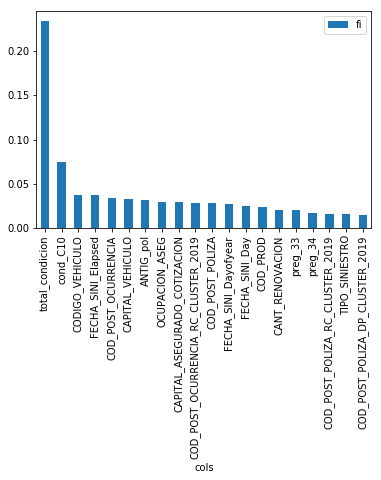

In [43]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [44]:
to_keep = list(rf_fi[rf_fi["fi"] >=0.005]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 36 of 151


In [45]:
to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "COD_CAUSA_SINI", 
            ] # "es_gte_5", "total_condicion", 

for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep

['total_condicion',
 'cond_C10',
 'CODIGO_VEHICULO',
 'FECHA_SINI_Elapsed',
 'COD_POST_OCURRENCIA',
 'CAPITAL_VEHICULO',
 'ANTIG_pol',
 'OCUPACION_ASEG',
 'CAPITAL_ASEGURADO_COTIZACION',
 'COD_POST_POLIZA',
 'FECHA_SINI_Dayofyear',
 'FECHA_SINI_Day',
 'COD_PROD',
 'CANT_RENOVACION',
 'preg_33',
 'preg_34',
 'TIPO_SINIESTRO',
 'FECHA_SINI_Week',
 'cond_C11',
 'FECHA_SINI_Dayofweek',
 'dias_entre_denu_y_sini',
 'SEGMENTO',
 'ESTAD_VEH_ASEG',
 'ESTADO_CIVIL',
 'COD_ZONA_ROBO',
 'FALTANTE',
 'CONV_COMISIONARIO',
 'preg_32',
 'CAPITAL_ACCESORIOS',
 'COD_COBRO_ANTERIOR']

In [84]:
# best model
best_model

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1.85},
            criterion='gini', max_depth=48, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [59]:
X_train_red = X_full_train[to_keep].copy()

In [60]:
print(len(X_train_red.columns))

30


### Training again with less features

In [61]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(best_model)
best_model.fit(X_train_red, y_full_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},
                       criterion='gini', max_depth=30, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=17,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [69]:
y_val_pred = rf.predict_proba(X_val[to_keep])[:, 1]

In [70]:
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred > 0.5), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.4756097560975609, 0.8873313988469241)

In [71]:
confusion_matrix(y_val, y_val_pred > 0.5)

array([[4508,  355],
       [  75,  195]])

In [72]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
0,total_condicion,0.235390
1,cond_C10,0.080628
4,COD_POST_OCURRENCIA,0.059460
9,COD_POST_POLIZA,0.048254
2,CODIGO_VEHICULO,0.047315
3,FECHA_SINI_Elapsed,0.045792
6,ANTIG_pol,0.039193
5,CAPITAL_VEHICULO,0.037943
8,CAPITAL_ASEGURADO_COTIZACION,0.036270
10,FECHA_SINI_Dayofyear,0.033964


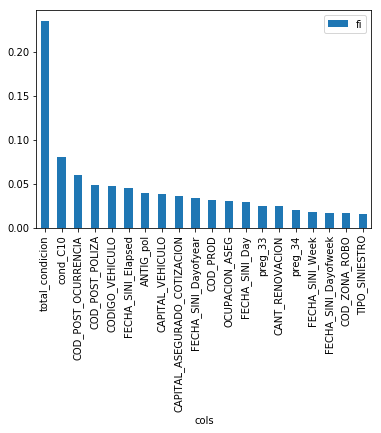

In [73]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
# best columns used
rf_fi["cols"].values

# final model

In [ ]:
# reset_rf_samples()

## full features final model

In [75]:
rf_full = copy(best_model)
rf_full.fit(X_full_train, y_full_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},
                       criterion='gini', max_depth=30, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=17,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [76]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.480, 0.897


In [77]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[4515,  348],
       [  75,  195]])

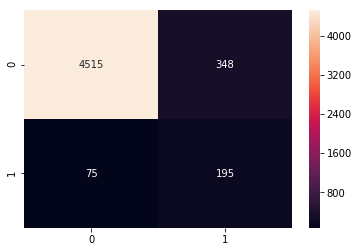

In [78]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## red features final model

In [80]:
rf_full = copy(best_model)
rf_full.fit(X_full_train[to_keep], y_full_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},
                       criterion='gini', max_depth=30, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=17,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [81]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.474, 0.892


In [82]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[4506,  357],
       [  75,  195]])

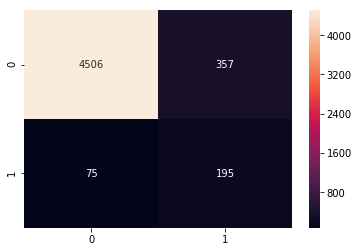

In [83]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador (sum cond >=5) comparison

In [84]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.470873786407767,0.8222450704868967)


In [85]:
conf_mat = confusion_matrix(y_val, y_tronador)
conf_mat

array([[4503,  360],
       [  76,  194]])

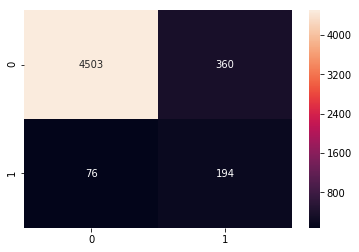

In [86]:
sns.heatmap(conf_mat, annot=True, fmt="d")

# Saving final model & columns used into hard drive

In [51]:
path_to_save = "../../src/models/1.1 - df_train 01-18to12-18/"
model_file = os.path.join(path_to_save, f"{model_id}(Model) - Model Optimization {metric} - class_weight {(rf_full.class_weight[0], rf_full.class_weight[1])} - time sorted - valid score ({metric_results}).pickle")

with open(model_file, "wb") as f:
    pickle.dump(rf_full, f, pickle.HIGHEST_PROTOCOL)

In [52]:
# save file for humans
# model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model for humans - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

# with open(model_file, "wb") as f:
#    pickle.dump(rf_full, f, 0) # 0 is human readable format

In [53]:
# merging list input & target
full_cols = list(to_keep)  # + ["EXISTE_FRAUDE"]
print(full_cols)

['cond_C10', 'TIPO_EXPED', 'preg_15', 'es_gte_5', 'preg_31', 'preg_33', 'cond_32', 'preg_32', 'cond_C11', 'cond_C12', 'cond_C2', 'METRO', 'SEXO_TERC', 'OCUPACION_ASEG', 'FALTANTE', 'preg_34', 'cond_C5']


In [54]:
path_to_save = "../../src/features/1.1 - df_train 01-18to12-18/"
columns_file = os.path.join(path_to_save, f"{model_id} (COLUMNS) - features: {len(full_cols)}.pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [81]:
# saving to use as example a few rows to implement the model
# path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
# sample_file = os.path.join(path_to_save, f"{model_id} (sample)  - dataset example to predict model.csv")

# df_example = X_val.loc[:, to_keep][-50:]
# df_example["EXISTE_FRAUDE"] = y_val[-50:]
# df_example.to_csv(sample_file)

In [ ]:
# df_example.head()

# Test prediction

In [95]:
df_test = pd.read_feather(os.path.join(path, "1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [53]:
# Loding the model

def load_model(file_name):
    """Load the dump model."""
    folder = "models"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    model_file = os.path.join(path_to_load, file_name)

    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(file_name):
    """Load the array of columns use in the dump model."""
    folder = "features"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    columns_file = os.path.join(path_to_load, file_name)

    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [54]:
model_name = "1.1.b.2.f(Model) - Model Optimization recall - class_weight (1, 18) - time sorted - valid score (0.403, 0.972).pickle"
columns_name = "1.1.b.2.f (COLUMNS) - features: 17.pickle"
m = load_model(model_name)
columns = load_columns(columns_name)

In [102]:
df_test = df_test[df_test["es_gte_5"] == True]
X_test = df_test[X_train.columns]
y_test = df_test["EXISTE_FRAUDE"]

In [103]:
X_test.head()

,cond_04,cond_05,cond_06,cond_09,cond_11,cond_12,cond_32,cond_37,cond_C1,cond_C10,cond_C11,cond_C12,cond_C13,cond_C14,cond_C15,cond_C16,cond_C17,cond_C18,cond_C19,cond_C2,cond_C20,cond_C21,cond_C3,cond_C4,cond_C5,cond_C6,cond_C7,cond_C8,cond_C9,total_condicion,es_gte_5,preg_1,preg_2,preg_3,preg_4,preg_5,preg_6,preg_7,preg_8,preg_9,preg_10,preg_11,preg_12,preg_15,preg_16,preg_18,preg_19,preg_22,preg_24,preg_27,preg_28,preg_30,preg_31,preg_32,preg_33,preg_34,preg_36,preg_37,CATASTROFICO,CERRADURA_BAUL,CERRADURA_DERECHA,CERRADURA_IZQUIERDA,CODIGO_BAJA,CODIGO_CARATULA,CODIGO_REAPERTURA,CODIGO_VEHICULO,COD_CAUSA_SINI,COD_POST_OCURRENCIA,COD_POST_POLIZA,COD_POST_TERC,COD_RAMO_sini,COD_RIES_sini,CONDICION_ROBO_EXP50,DANOS_MATERIALES,DESCRIPCION_TIPO,ESTADO_CIVIL,ESTADO_CIVIL_TERC,ESTAD_VEH_ASEG,FALTANTE,MCA_COASEG,MCA_JUICIO,MCA_VIP,METRO,OCUPACION_ASEG,SEXO,SEXO_TERC,TELEFONO_TERC,TIPO,TIPO_EXPED,TIPO_LESION,TIPO_LESION_MAXIMA,TIPO_SINIESTRO,USO,dias_entre_denu_y_sini,dist_fformal_fsini,dist_fformal_fdenu,existe_FECHA_FORMAL,CANT_RENOVACION,CAPITAL_ACCESORIOS,CAPITAL_ASEGURADO_COTIZACION,CAPITAL_VEHICULO,COD_COBRO,COD_COBRO_ANTERIOR,COD_PROD,COD_ZONA_CASCO,COD_ZONA_RC,COD_ZONA_ROBO,CONV_COMISIONARIO,CIF_ID,MCA_AGRAVANTE,MCA_EMPLEADO,MCA_MOVIMIENTO,MCA_POLIZA_VIP,NEGOCIO,PRENDARIO,SEGMENTO,cambio_cobro,ANTIG_pol,COD_EST_CIVIL,TIPO_ACTIVIDAD,CLIENTE,CODIGO_NACION,DATECO_TIPO_ACTIVIDAD,DOMICILIO_CODIGO_POSTAL,HABILITADO,FECHA_SINI_Year,FECHA_SINI_Month,FECHA_SINI_Week,FECHA_SINI_Day,FECHA_SINI_Dayofweek,FECHA_SINI_Dayofyear,FECHA_SINI_Is_month_end,FECHA_SINI_Is_month_start,FECHA_SINI_Is_quarter_end,FECHA_SINI_Is_quarter_start,FECHA_SINI_Is_year_end,FECHA_SINI_Is_year_start,FECHA_SINI_Hour,FECHA_SINI_Minute,FECHA_SINI_Second,FECHA_SINI_Elapsed,cant_pol,cant_sini_1y,COD_POST_POLIZA_DP_CLUSTER_2019,COD_POST_POLIZA_RT_CLUSTER_2019,COD_POST_POLIZA_RC_CLUSTER_2019,COD_POST_OCURRENCIA_DP_CLUSTER_2019,COD_POST_OCURRENCIA_RT_CLUSTER_2019,COD_POST_OCURRENCIA_RC_CLUSTER_2019,COD_POST_TERC_DP_CLUSTER_2019,COD_POST_TERC_RT_CLUSTER_2019,COD_POST_TERC_RC_CLUSTER_2019
23,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,0.0,0.0,3.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0,True,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,1,293,-1,-1,0,0,0,0,-1.0,-1.0,-1.0,2035.0,209.0,1754.0,1766.0,-1.0,1.0,1.0,-1.0,0,2,6,-1,3.0,0,0,-1,1,1,8.0,1,-1,-1,6.0,6,-1,-1,7,1.0,0.0,-1.0,-1.0,0,35.0,182,1475,2781,5,5,6030.0,1.0,1.0,1.0,107,-1.0,0,0,-1,1,21,0,4,0,1034.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1554076800,0.0,0.0,29.0,10.0,25.0,29.0,10.0,25.0,-1.0,-1.0,-1.0
283,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,5.0,0.0,0.0,-1.0,0.0,1.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6.0,True,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,1,-1,-1,-1,0,0,0,0,-1.0,-1.0,-1.0,12600.0,209.0,1706.0,1406.0,-1.0,1.0,1.0,-1.0,0,3,0,-1,3.0,1,0,-1,1,1,99999.0,1,-1,-1,3.0,6,-1,-1,5,1.0,0.0,-1.0,-1.0,0,29.0,8,1446,2099,5,5,6060.0,1.0,1.0,3.0,107,-1.0,0,0,-1,1,21,0,6,0,850.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1554076800,0.0,0.0,15.0,5.0,19.0,25.0,8.0,26.0,-1.0,-1.0,-1.0
336,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,0.0,0.0,2.0,-1.0,-1.0,-1.0,-1.0,5.0,True,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,-1,1,-1,-1,-1,-1,122,134,1,-1,0,-1,-1,-1,-1,0,-1,-1,-1,-1.0,-1.0,-1.0,24360.0,201.0,2000.0,2300.0,-1.0,1.0,1.0,1.0,0,13,6,-1,3.0,1,0,-1,0,0,5.0,0,-1,-1,9.0,5,-1,-1,7,1.0,0.0,-1.0,-1.0,0,2.0,8,3836,8132,2,2,72038.0,4.0,22.0,22.0,16,-1.0,0,0,-1,0,47,1,4,0,182.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1554076800,0.0,0.0,8.0,3.0,15.0,10.0,3.0,30.0,-1.0,-1.0,-1.0
470,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,0.0,0.0,2.0,-1.0,-1.0,-1.0,-1.0,5.0,T

## Model in test

In [104]:
# using trained model
y_test_pred_prob = best_model.predict_proba(X_test)[:, -1]

# Using load model
# y_test_pred_prob = m.predict_proba(X_test)[:, -1]

print("%.3f, %.3f" % (f1_score(y_test, y_test_pred_prob > 0.5), roc_auc_score(y_test, y_test_pred_prob)))

0.444, 0.692


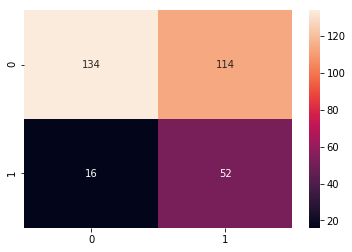

In [105]:
conf_mat = confusion_matrix(y_test, y_test_pred_prob > 0.5)
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador in test

In [100]:
y_tronador = X_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))

0.330, 0.851


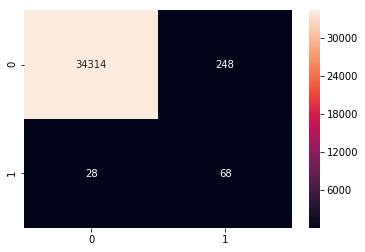

In [101]:
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")